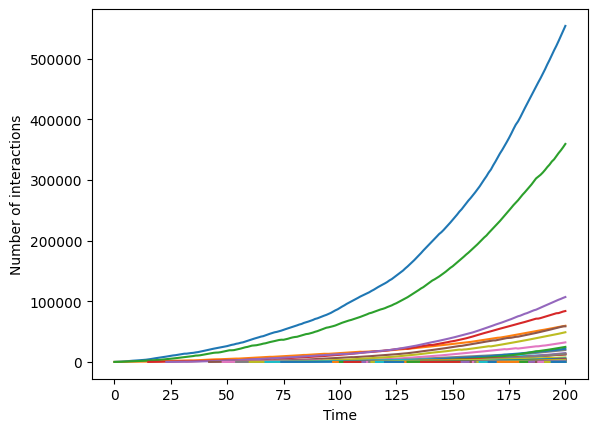

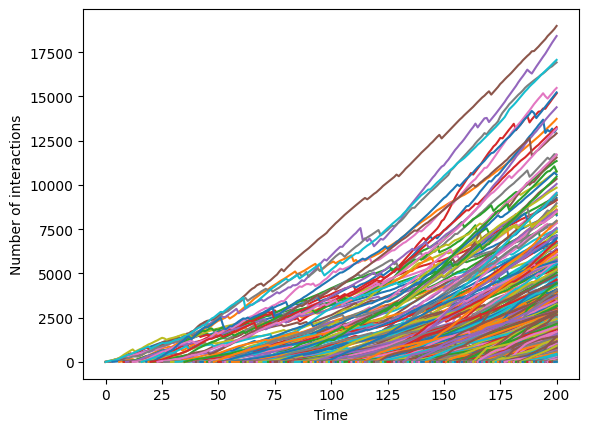

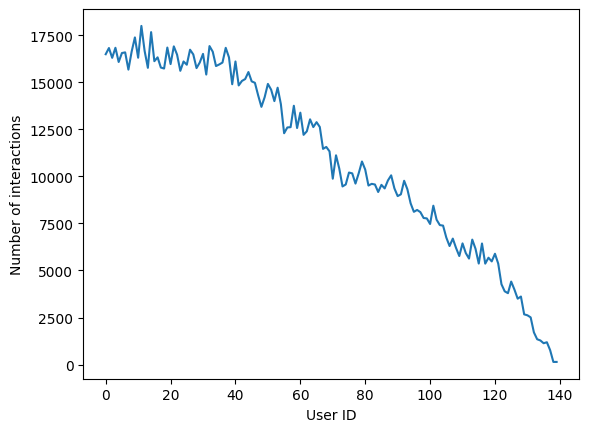

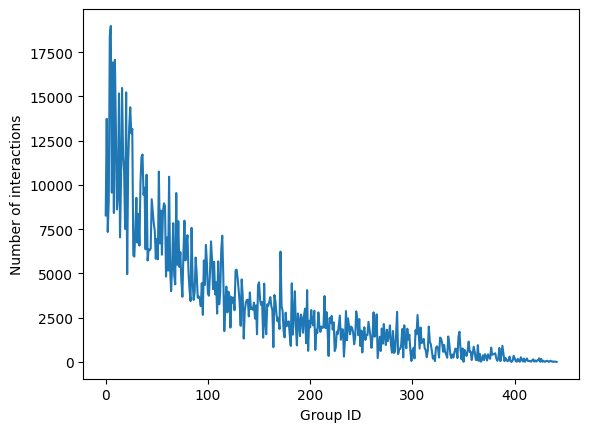

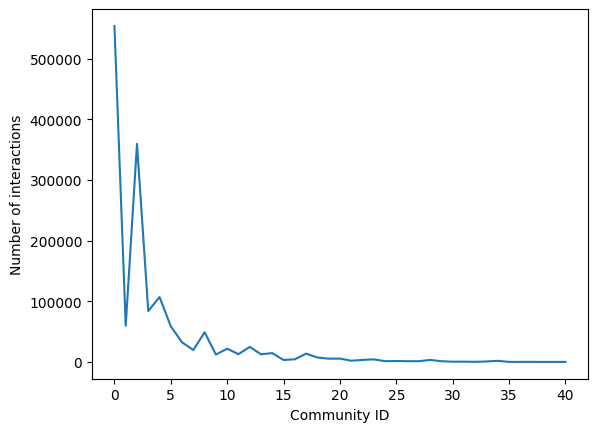

In [244]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt 
from math import floor

class Community:
    def __init__(self, group=None):
        # Initialize a community with a list of users and groups
        self.id = len(communities) + 1
        self.groups = [group] if group else []
        self.interactions = []

class Group:
    def __init__(self):
        # Initialize a group with an ID and a dictionary tgo track user interactions
        self.id = len(groups) + 1
        self.interactions = {}
        self.community : Community = None

    def join_community(self, community : Community):
        community.groups.append(self)
        self.community = community

class User:
    def __init__(self, group_alpha, group_beta, community_alpha, community_beta):
        # Initialize a user with ID, group memberships, interaction history, and Beta distribution preferences
        self.id = 0

        self.groups = []
        self.communities = []
        self.interaction_history = []

        self.group_preferences = stats.beta(group_alpha, group_beta)
        self.community_preferences = stats.beta(community_alpha, community_beta)


    def update_preferences(self):
        # Update user's preferences based on group interactions
        if not self.groups:
            self.updated_preferences = np.array([1])
            return
        else:
            #sort groups by number of interactions
            self.groups.sort(key=lambda group: len(group.interactions))

        total_size = sum([len(group.interactions) for group in self.groups])

        if total_size == 0:
            self.ccdf = np.array([1])
            return
        else:
            sizes = sorted([len(group.interactions) for group in self.groups])
            self.ccdf = 1 - (np.cumsum(sizes) / total_size)

        group_convolution = np.convolve(self.group_preferences.pdf(np.linspace(0, 1, len(self.groups))), self.ccdf , mode='same')

        self.updated_preferences = np.convolve(group_convolution, self.community_preferences.pdf(np.linspace(0, 1, len(self.groups))), mode='same')

        if np.isnan(self.updated_preferences).any() or np.sum(self.updated_preferences) == 0:
            self.updated_preferences = np.array([1 / len(self.groups)] * len(self.groups))
        else:
            self.updated_preferences /= np.sum(self.updated_preferences)

    def join_group(self, group):
        # Add a group to the user's group list and set initial interactions to 0
        self.groups.append(group)
        group.interactions[self] = 0

    def interact(self, group: Group):
        # Record an interaction with the specified group
        group.interactions[self] = group.interactions.get(self, 0) + 1
        self.interaction_history.append(group.id)


# Initialize lists to store users and groups
users = []
groups = []
communities = []

num_groups = len(groups)
num_communities = len(communities)


# Define simulation parameters
num_timesteps = 200

user_growth_rate = 0.05

group_join_rate = 0.00625
same_community_interaction_rate = 0.05

new_group_threshold = 0.05
new_community_threshold = 0.1
interaction_threshold = 1

alpha_group_hyperparameter = 10
beta_group_hyperparameter = 10 

alpha_community_hyperparameter = 10
beta_community_hyperparameter = 10

initial_users = 20
initial_groups = 10
initial_communities = 3


# Data structure for regression analysis
user_interactions = []
group_interactions = []
community_interactions = []


# Create initial users and groups
for _ in range(initial_users):
    user = User(np.random.uniform(1, alpha_group_hyperparameter),
                np.random.uniform(1, beta_group_hyperparameter),
                np.random.uniform(1, alpha_community_hyperparameter),
                np.random.uniform(1, beta_community_hyperparameter))
    users.append(user)
    user.id = len(users)

for _ in range(initial_communities):
    community = Community()
    communities.append(community)

    group = Group()
    groups.append(group)
    
    community.groups.append(group)

for _ in range(initial_groups - initial_communities):
  
    community = np.random.choice(communities)

    group = Group()
    group.id = len(groups) + 1
    group.join_community(community)
    groups.append(group)

# Initial user-group interactions
for user in users:
    for _ in range(floor(stats.expon.rvs(group_join_rate))):
        group = np.random.choice(groups)
        user.join_group(group)
    user.update_preferences()

for user in users:
    if user.groups:
        if np.random.rand() < interaction_threshold:
            group = np.random.choice(user.groups, p=user.updated_preferences)
            user.interact(group)        

# Record initial user interactions
for user in users:
    interactions_by_group = np.bincount([group.id for group in user.groups], minlength=num_groups)
    user_interactions.append([user.id, 0, *interactions_by_group])

gis = []        
for group in groups:
    gis.append(sum(list(group.interactions.values())))
group_interactions.append(gis)

cis = []
for community in communities:
    cis.append(sum([sum(list(group.interactions.values())) for group in community.groups]))
community_interactions.append(cis)

interactions = sum([len(group.interactions) for group in groups])

# Recalculate probabilities at every iteration or after any changes
def calculate_probabilities():
    global community_relative_frequency, group_relative_frequency

    community_relative_frequency = np.array([len(community.groups) for community in communities], dtype=float)
    if community_relative_frequency.sum() != 0:
        community_relative_frequency += 1e-5  # Avoid division by zero
        community_relative_frequency /= community_relative_frequency.sum()

    group_relative_frequency = np.array([sum(group.interactions.values()) for group in groups], dtype=float)
    if group_relative_frequency.sum() != 0:
        group_relative_frequency += 1e-5
        group_relative_frequency /= group_relative_frequency.sum()

# Initialize probabilities
# Main simulation loop
for time in range(num_timesteps):

    calculate_probabilities()


    for _ in range(floor(stats.expon.rvs(user_growth_rate))): 
        user = User(np.random.uniform(1, alpha_group_hyperparameter),
                    np.random.uniform(1, beta_group_hyperparameter),
                    np.random.uniform(1, alpha_community_hyperparameter),
                    np.random.uniform(1, beta_community_hyperparameter))
        users.append(user)
        user.id = len(users)

    for user in users:
        
        for _ in range(floor(stats.expon.rvs(group_join_rate))):

            calculate_probabilities()


            if np.random.rand() < new_group_threshold:
                group = Group()
                user.join_group(group)
                groups.append(group)


                if communities:  # Check if the list is not empty
                    if np.random.rand() < new_community_threshold:
                        community = Community(group)
                        communities.append(community)
                        group.join_community(community)
                    else:
                        community = np.random.choice(communities, p=community_relative_frequency)
                        group.join_community(community)

            else:
                if groups:  # Check if the list is not empty
                    group = np.random.choice(groups)
                    user.join_group(group)
                    
        if user.groups:
            user.update_preferences()
        else:
            user.updated_preferences = np.array([1])

        num_groups = len(groups)
        num_communities = len(communities)

        for user in users:
            if np.random.uniform() < interaction_threshold and user.groups:
                group = np.random.choice(user.groups, p=user.updated_preferences)

                if group.community:  # Check if the group is associated with a community
                    community = group.community

                    for _ in range(floor(same_community_interaction_rate * (len(community.groups) + 1))):
                        if np.random.uniform() < same_community_interaction_rate and community.groups:
                            group_comm = np.random.choice(community.groups)
                            user.interact(group_comm)

                    user.interact(group)
                    current_group = user.interaction_history[-1]
                else:
                    # join a community based on the probability distribution
                    community = np.random.choice(communities, p=community_relative_frequency)
                    group.join_community(community)
            else:
                user.interaction_history.append(1)
                current_group = user.interaction_history[-1]
            
        calculate_probabilities()


        if len(user.interaction_history) > 1:
            previous_group = user.interaction_history[-2]
            interactions_by_group = np.bincount(user.interaction_history, minlength=num_groups)
            user_interactions.append([user.id,current_group, *interactions_by_group])
        else:
            previous_group = current_group
            interactions_by_group = np.bincount(user.interaction_history, minlength=num_groups)
            user_interactions.append([user.id,current_group, *interactions_by_group])

    gis = []        
    for group in groups:
        gis.append(sum(list(group.interactions.values())))
    group_interactions.append(gis)

    cis = []
    for community in communities:
        cis.append(sum([sum(list(group.interactions.values())) for group in community.groups]))
    community_interactions.append(cis)

    calculate_probabilities()


community_interactions = pd.DataFrame(community_interactions)

for community in communities:
  c = community_interactions.iloc[:,community.id-1]
  plt.plot(c)

plt.xlabel('Time')
plt.ylabel('Number of interactions')
plt.show()

group_interactions = pd.DataFrame(group_interactions)

for group in groups:
  g = group_interactions.iloc[:,group.id-1]
  plt.plot(g)

plt.xlabel('Time')
plt.ylabel('Number of interactions')
plt.show()

uis = []
for user in users:
    uis.append(len(user.interaction_history))

plt.plot(uis)
plt.xlabel('User ID')
plt.ylabel('Number of interactions')
plt.show()


plt.plot(group_interactions.iloc[-1])
plt.xlabel('Group ID')
plt.ylabel('Number of interactions')
plt.show()

plt.plot(community_interactions.iloc[-1])
plt.xlabel('Community ID')
plt.ylabel('Number of interactions')
plt.show()